# Курсовой проект Megafon

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Данные**

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

Итого, в качестве входных данных будут представлены:

- data_train.csv: id, vas_id, buy_time, target

- data_test.csv: id, vas_id, buy_time

- features.csv.zip: id, <feature_list> 


И тестовый набор:

- data_test.csv: id, vas_id, buy_time
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
- buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
- id - идентификатор абонента
- vas_id - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.

**Метрика**

Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).

sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation


**Формат представления результата**

1.	Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.

2.	Код модели можно представить в виде jupyter-ноутбука. 

3.	Презентация в формате .pdf, в которой необходимо отразить:
- Информация о модели, ее параметрах, особенностях и основных результатах.
- Обоснование выбора модели и ее сравнение с альтернативами.
- Принцип составления индивидуальных предложений для выбранных абонентов.

Рекомендуемое количество слайдов – 5 – 10.

Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.

In [1]:
conda install -c anaconda luigi 

Solving environment: done

## Package Plan ##

  environment location: /Users/alenakukhta/opt/anaconda3

  added / updated specs:
    - luigi


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.10.26~ --> anaconda::ca-certificates-2020.10.14-0
  certifi            pkgs/main::certifi-2021.10.8-py38hecd~ --> anaconda::certifi-2020.6.20-py38_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c conda-forge/label/cf201901 luigi

Solving environment: done

## Package Plan ##

  environment location: /Users/alenakukhta/opt/anaconda3

  added / updated specs:
    - luigi


The following packages will be UPDATED:

  certifi                anaconda::certifi-2020.6.20-py38_0 --> pkgs/main::certifi-2021.10.8-py38hecd8cb5_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    anaconda::ca-certificates-2020.10.14-0 --> conda-forge/label/cf201901::ca-certificates-2018.11.29-ha4d7672_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge/label/cf202003 luigi

Solving environment: done

## Package Plan ##

  environment location: /Users/alenakukhta/opt/anaconda3

  added / updated specs:
    - luigi


The following packages will be UPDATED:

  ca-certificates    conda-forge/label/cf201901::ca-certif~ --> conda-forge/label/cf202003::ca-certificates-2019.11.28-hecc5488_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            pkgs/main::certifi-2021.10.8-py38hecd~ --> conda-forge/label/cf202003::certifi-2019.11.28-py38h32f6830_1


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install -c https://conda.anaconda.org/akode xgboost

Solving environment: done

## Package Plan ##

  environment location: /Users/alenakukhta/opt/anaconda3

  added / updated specs:
    - xgboost


The following packages will be UPDATED:

  ca-certificates    conda-forge/label/cf202003::ca-certif~ --> pkgs/main::ca-certificates-2021.10.26-hecd8cb5_2
  certifi            conda-forge/label/cf202003::certifi-2~ --> pkgs/main::certifi-2021.10.8-py38hecd8cb5_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [5]:
! pip install catboost

In [6]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,\
precision_recall_curve, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import pickle
import luigi
import gc
from datetime import datetime, date, time
from datetime import timedelta

pd.pandas.set_option('display.max_columns', None)
import warnings
warnings.simplefilter('ignore')

from functions import reduce_mem_usage, get_classification_report, show_feature_importances, \
show_proba_calibration_plots, plot_confusion_matrix

from sklearn.decomposition import PCA
import scipy.sparse
from sklearn.cluster import KMeans

In [7]:
TRAIN_PATH = "data_train.csv"
TEST_PATH = "data_test.csv"
FEATURES_PATH = "features.csv"

In [8]:
data_train = pd.read_csv(TRAIN_PATH)
data_test = pd.read_csv(TEST_PATH)

Обзор train и test

In [9]:
data_train.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [10]:
print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB
None


In [11]:
#уменьшение потребляемой памяти (из functions.py)
data_train = reduce_mem_usage(data_train)
data_test = reduce_mem_usage(data_test)

Memory usage of the dataframe is 31.73 MB
Memory usage after optimization is: 15.86 MB
Decreased by 50.0%
Memory usage of the dataframe is 2.17 MB
Memory usage after optimization is: 1.09 MB
Decreased by 50.0%


In [12]:
#уникальные значения:
for col in data_train.columns[1:-1]:
    print(f'{col}  -->  {data_train[col].nunique()} + \
    {data_test[~data_test[col].isin(np.unique(data_train[col]))].shape[0]} новых значений в тесте')

id  -->  806613 +     67013 новых значений в тесте
vas_id  -->  8 +     0 новых значений в тесте
buy_time  -->  26 +     71231 новых значений в тесте


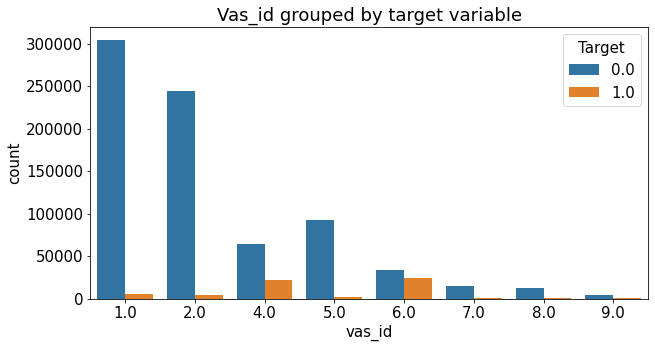

In [13]:
plt.figure(figsize=(10, 5))

sns.countplot(x="vas_id", hue=data_train['target'], data=data_train)
plt.title('Vas_id grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.savefig("vas_id-target2.png")

plt.show()

**Выводы:** различные услуги предлагались разному количеству абонентов, соотношение подключений услуг и отказов также отличается. 

На следующем графике показано соотношение подключений и отказов вне зависимости от кол-ва предложений абонентам, что впоследствии окажется более полезным признаком для модели:

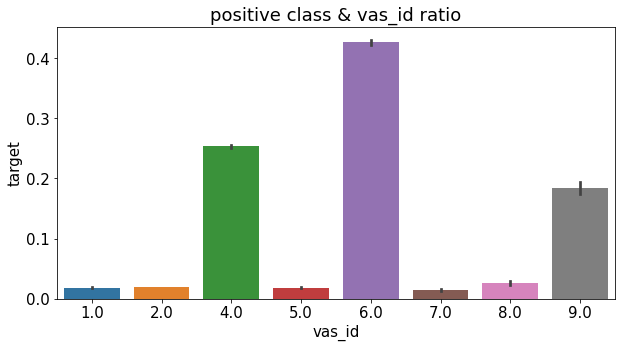

In [14]:
plt.figure(figsize=(10, 5))

sns.barplot("vas_id", 'target', data=data_train)
plt.title('positive class & vas_id ratio')
plt.savefig("vas_id-target.png")
plt.show()

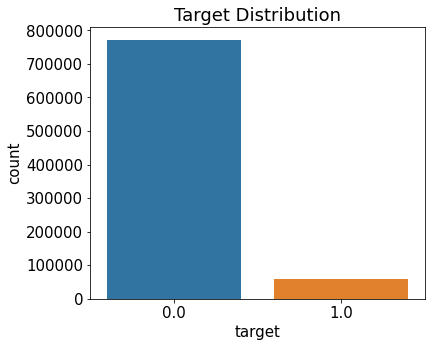

In [15]:
plt.figure(figsize=(6, 5))
plt.title('Target Distribution')

sns.countplot(x='target', data=data_train)
plt.savefig("target.png")

Наблюдается значительный дисбаланс между классами, что может негативно сказаться на результате работы модели. Добавлять синтетические данные или дубликаты строк миноритарного класса не хочется, т.к. датасет и без того огромный и тяжелый, также могут нарушиться закономерности в датах. Поэтому веса классов принято решение корректировать непосредственно в модели

#### Обзор features

Поскольку датасет весит > 20Гб, сразу уменьшим его и включим только тех пользователей, которые есть в train и test данных.

In [16]:
def process_featues(data_features, train, test):
    ids = np.unique(train['id'].append(test['id']))
    data_features = data_features[data_features['id'].isin(ids)]
    if 'Unnamed: 0' in data_features:
        data_features = data_features.drop(columns='Unnamed: 0')
    
    data_features = data_features.compute()
    # удалим признаки с единственным значением
    df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
    const = df_nunique[df_nunique ==1].index.tolist()
    data_features = data_features.drop(columns = const)
    return reduce_mem_usage(data_features)

In [17]:
data_features = dd.read_csv(FEATURES_PATH, sep ='\t')
data_features =process_featues(data_features, data_train, data_test)

Memory usage of the dataframe is 1728.06 MB
Memory usage after optimization is: 867.47 MB
Decreased by 49.8%


In [18]:
data_features.corr()

,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
id,1.000000,0.074840,-0.018533,-0.049811,-0.019042,-0.047225,-0.020980,-0.048451,-0.005416,-0.015210,-0.005240,-0.011587,-0.001216,-0.003679,-0.005242,-0.024060,-0.025880,0.001631,-0.000302,0.000161,-0.012227,0.002342,-0.005751,-0.019417,-0.020158,-0.001046,-0.001341,0.020735,0.031846,-0.012900,-0.016203,-0.019196,-0.018793,-0.026962,-0.001416,-0.001509,-0.013364,0.000576,-0.000429,-0.004331,0.027505,0.021553,0.019050,0.019211,0.025536,-0.013023,-0.015466,-0.008365,0.018783,0.004164,-0.003233,0.000263,-0.012622,-0.011468,-0.010804,-0.016719,-0.001796,-0.002997,-0.003312,0.001372,-0.025255,-0.110329,-0.013646,-0.013864,-0.019514,-0.010480,-0.005025,-0.010429,-0.007208,0.011375,0.007764,0.005213,0.012182,-0.001179,-0.005330,-0.004122,0.003980,0.012869,0.015264,-0.001323,-0.001250,-0.001303,-0.006782,-0.003457,-0.000642,-0.003601,-0.003258,-0.003030,-0.007343,-0.005391,-0.003748,-0.003582,-0.001365,0.000310,-0.000256,0.003758,-0.004141,-0.003020,0.002661,-0.007093,-0.004359,0.001504,-0.001568,0.001929,-0.003048,0.009817,0.000456,-0.009676,-0.005235,0.007548,0.001889,0.021544,0.018987,-0.016944,-0.019235,0.027448,0.046326,-0.005018,-0.000303,0.000020,-0.004364,-0.002011,0.019320,0.025543,0.030714,0.010822,0.018232,-0.007783,-0.004995,-0.020430,-0.024167,-0.003760,0.003719,-0.034033,-0.037130,-0.044315,-0.032439,-0.039517,-0.014309,-0.002940,-0.004201,-0.016217,-0.028622,-0.036792,0.025819,0.006187,-0.006535,0.005164,0.005219,-0.013180,-0.007232,-0.007738,-0.001104,-0.001729,0.003301,0.002257,-0.000686,-0.000811,-0.008449,0.000839,-0.002157,0.002016,-0.022922,0.042078,0.033112,0.053616,0.038834,-0.013305,-0.015462,0.007681,0.003496,-0.008548,-0.004119,-0.007720,-0.007069,-0.004269,-0.002435,-3.572096e-03,-0.003102,0.013457,0.011521,0.023971,0.020969,0.007551,-0.008367,0.019777,0.001264,-0.000113,-0.000828,-0.016292,-0.120043,-0.125707,0.033121,-0.050106,-0.061164,-0.015422,-0.107165,0.004836,-0.008694,-0.038640,0.000844,0.033718,-0.094019,0.000052,-0.044728,0.038582,0.007635,-0.010630,0.002465,-0.014136,0.002705,-0.000216,-0.006314,-6.197861e-04,0.007637,0.002412,0.006283,-0.001107,0.002661,-0.008353,-0.018766,-0.115517,-0.022566,-0.071502,-0.000391,0.004461,0.021617,0.012696,-0.002548,0.001306,0.007481,0.011321,0.006918,0.046921,0.002078,0.025633,0.018830,0.041320,0.033575,0.008622,0.033406,0.031321,0.001759,0.018031,0.016822,0.007157,-0.003176,-0.001042,-0.002227,-0.011229
buy_time,0.074840,1.000000,-0.020798,-0.056733,-0.020246,-0.050396,-0.027111,-0.061522,-0.011254,-0.022163,-0.013326,-0.024264,-0.011507,-0.003426,-0.009533,-0.012718,-0.018461,0.000974,-0.003376,-0.004625,-0.034906,-0.027668,0.000493,-0.025649,-0.007162,-0.001749,-0.002342,0.026137,-0.039176,-0.009274,0.043352,0.052105,0.053781,-0.008408,-0.002343,-0.002728,-0.014717,-0.004623,-0.023212,-0.008936,0.027655,-0.002751,0.036413,-0.010169,0.024222,-0.034550,-0.023695,-0.036358,-0.014749,0.001710,-0.000308,-0.000196,-0.052366,-0.051358,-0.059623,-0.055125,-0.020017,-0.021721,-0.023750,-0.004457,-0.097688,-0.091455,-0.011331,-0.014591,-0.043179,-0.008901,-0.011189,-0.000060,-0.000363,-0

**Выводы:**

У многих признаков высокий уровень корреляции между собой, поэтому, вероятно, некоторые из них можно удалить.

Распределение многих признаков похоже: значения 25, 50, 75 перцинтилей одинаковы, средние отличаются незначительно,  минимальные и максимальные значения отличаются.

In [19]:
tmp = data_train.merge(data_features, on='id', how = 'left')

In [20]:
tmp[tmp.columns[6:]].loc[tmp.target==1].describe() - tmp[tmp.columns[6:]].loc[tmp.target==0].describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
count,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.00000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-7.356380e+05,-735638.00000,-735638.000000,-735638.000000,-7.356380e+05,-735638.00

In [21]:
del tmp

**Вывод:** желательно выбрать минимальное количество признаков, чтобы сделать работу модели менее ресурсозатратной. Вероятнее всего, это возможно, поскольку не все признаки репрезентативны

### Подготовка датасета

In [22]:
X = data_train.drop('target', axis=1)
y = data_train['target']

Объединим train и features и добавим новые признаки, создадим пайплайн для обработки датасета. Подавляющее большинство дат в features и train не совпадают, различных дат и обновлений профилий в features довольно мало, результат работы модели практически не меняется в зависимости от способа объединения датасетов.

In [23]:
class DataTransform(BaseEstimator, TransformerMixin):

    def __init__(self, features):
        self.data = None
        self.target = None
        self.features = features.copy()
        self.vas_id_dict1 = None
        self.vas_id_dict2 = None
        self.vas_id_dict3 = None
        self.q_list = None
        self.first_day = None


        
    def fit(self, data, target):
        self.data = data.copy()
        self.target = target.astype('int')
        X = pd.concat([data, target], axis=1)
        # доля подключений услуги по сравнению с отказами
        self.vas_id_dict1 = dict(X.groupby('vas_id')['target'].mean())
        # соотношение подключений по всем услугам
        self.vas_id_dict2 = dict(X.loc[X['target']==1]['vas_id'].value_counts(normalize=True))
        # доля предложений услуги
        self.vas_id_dict3 = dict(X['vas_id'].value_counts(normalize=True))
        #максимальные 20% значений по признакам из features
        self.q_list = [np.quantile(self.features[el], q=0.8) for el in self.features][2:]
        self.first_day = data['buy_time'].min()
        

        return self

    
    def transform(self, data):
   
        if 'Unnamed: 0' in data.columns:
            data.drop(columns='Unnamed: 0', inplace=True)
        data = reduce_mem_usage(data)
        
        # при сравнении распределения признаков в зависимости от целевой переменной в таблице выше видно, что
        # наибольшая разница наблюдается верхнем квартиле. Посчитаем значения выше 0.8 квантиля
        self.features['highest_value'] = 0
        for i, col in enumerate(self.features.columns[2:-1]):
            self.features.loc[self.features[col] > self.q_list[i], 'highest_value'] +=1
        
        
        self.features.drop_duplicates('id', keep='first', inplace=True)
        prepared_df = pd.merge(data, self.features, how='left', on='id')
        
        prepared_df.rename(columns={'buy_time_x': 'buy_time'}, inplace=True)
        

        # будем считать кол-во дней с 1го дня train периода
        prepared_df['count_days'] = (prepared_df['buy_time'] - self.first_day) //86400
        
        # доля подключений услуги по сравнению с отказами
        prepared_df['vas_id1'] = prepared_df['vas_id'].replace(self.vas_id_dict1)
        
        #prepared_df['vas_id2'] = prepared_df['vas_id'].replace(self.vas_id_dict2)
        #prepared_df['vas_id3'] = prepared_df['vas_id'].replace(self.vas_id_dict3)
       # prepared_df['date'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x))
       # prepared_df['month'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x).month)
        prepared_df['day'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x).day)
        prepared_df['weekofyear'] = prepared_df['buy_time'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).weekofyear)
        
        
        """
        Некоторым пользователям сделано несколько предложений. Сохраним информацию, какую услугу пользователю
        уже предлагали (каждую отдельно), сколько у него всего предложений, в какой последовательности предлагали
        услуги, какая разница по времени между предложениями услуг
        
        """
        tmp = prepared_df[['id', 'buy_time', 'vas_id']].merge(self.data[['id', 'buy_time', 'vas_id']],\
                                                              on=['id', 'buy_time', 'vas_id'], how='outer')
        tmp = tmp.loc[tmp['id'].isin(prepared_df['id'])]
        tmp2 = tmp.groupby('id')['vas_id'].count().reset_index()
        tmp2 = tmp2.loc[tmp2['vas_id']>1]
        tmp['buy_time'] = (tmp['buy_time'] - self.first_day) //86400
        tmp.rename(columns={'buy_time': 'count_days'}, inplace=True)
        # будем считать предложения только для тех пользователей, у которых их больше 1
        tmp = tmp.loc[tmp['id'].isin(tmp2['id'])].sort_values(['id', 'count_days']).reset_index(drop=True)
        tmp['1.0'] = 0 
        tmp['2.0'] = 0
        tmp['4.0'] = 0
        tmp['5.0'] = 0
        tmp['6.0'] = 0
        tmp['7.0'] = 0
        tmp['8.0'] = 0
        tmp['9.0'] = 0
        
        checked_id = 0
        counter = 1
        tmp['count_offers'] = 1
        tmp['time_delta'] = 0

        for i in range(tmp.shape[0]):
            if tmp.iloc[i]['id'] != checked_id:
                checked_id = tmp.iloc[i]['id']
                counter = 1   
            else:
                counter +=1
                tmp.loc[i, 'count_offers'] = counter
                tmp.loc[i, 'time_delta'] = tmp.iloc[i]['count_days'] - tmp.iloc[i-1]['count_days']
            tmp.loc[i, str(tmp.iloc[i]['vas_id'])] +=1
                
        prepared_df = prepared_df.merge(tmp[['id', 'vas_id','count_days', 'count_offers','time_delta']],\
                                        on=['id', 'vas_id','count_days'], how='left')
        prepared_df = prepared_df.merge(tmp.groupby('id').agg({'1.0': 'sum', '2.0':'sum', '4.0': 'sum', 
                    '5.0':'sum', '6.0': 'sum', '7.0':'sum', '8.0': 'sum', '9.0':'sum'}).reset_index(), on='id', how='left')
        
        #остальным пользователям проставим 1 предложение
        prepared_df['count_offers'] = prepared_df['count_offers'].fillna(1)
        prepared_df['time_delta'] = prepared_df['time_delta'].fillna(0)
        prepared_df['1.0'] = prepared_df['1.0'].fillna(0).rename('offer_1')
        prepared_df['2.0'] = prepared_df['2.0'].fillna(0).rename('offer_2')
        prepared_df['4.0'] = prepared_df['4.0'].fillna(0).rename('offer_4')
        prepared_df['5.0'] = prepared_df['5.0'].fillna(0).rename('offer_5')
        prepared_df['6.0'] = prepared_df['6.0'].fillna(0).rename('offer_6')
        prepared_df['7.0'] = prepared_df['7.0'].fillna(0).rename('offer_7')
        prepared_df['8.0'] = prepared_df['8.0'].fillna(0).rename('offer_8')
        prepared_df['9.0'] = prepared_df['9.0'].fillna(0).rename('offer_9')

        
        prepared_df.drop(['id','buy_time'], axis=1, inplace=True)
        
               
        
        return prepared_df

Изначально в пайплайн подавались все имеющиемя данные, но многие признаки оказались незначимыми для модели. Поскольку данные анонимизированы и нормализованы, сложно понять, какие из них являются категориальными и не имеют количественной взаимосвязи. Пробовала считатать признаки с < 10 уникальных значений категориальными, с 2мя значениями - бинарными.

В итоге лучший результат получился, если посчитать все анонимизированные признаки из features количественными и воспользоваться методом pca. За несколько итераций удалось значительно сократить кол-во признаков без потери качества. За 1 итерацию качественно сократить кол-во признаков до минимума не получилось, поскольку в разных сочетаниях у них разные веса, сразу из 250 признаков выделить 10 главных компонент получилось не очень хорошо.

Итого оставим:

- 1 категориальный признак
- 10 количественных признаков после РСА
- новые фичи оставим без изменений

In [24]:
#df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
#bool_features = df_nunique[df_nunique ==2].index.tolist()
#cat_features = df_nunique[df_nunique <=10].index.tolist()
#num_features = np.setdiff1d(data_features.columns[2:], cat_features)
#cat_features = np.append(np.setdiff1d(cat_features, bool_features),'vas_id')
#other_features = ['highest_value', 'count_days', 'vas_id1', 'day', 'weekofyear', 'count_offers',
#       'time_delta', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [25]:
num_features = data_features.columns[2:]
cat_features = ['vas_id']
bool_features = []
other_features = ['highest_value', 'count_days', 'vas_id1', 'day', 'weekofyear', 'count_offers',
       'time_delta', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [26]:
class PCA_transformer(BaseEstimator, TransformerMixin):

    def __init__(self, num_features):
        self.num_features = num_features
        # постепенно сократим кол-во компонент до 10
        self.steps = [80, 40, 25, 15, 10]
        self.X = None

    def fit(self, X, y=None):
        self.X = X.copy()
        return self

    def transform(self, X, y=None):
        data = X[self.num_features].copy()
        for step in self.steps:
            pca = PCA(n_components=step, svd_solver='full')
            data = pca.fit_transform(data)
        col_names = ['pca' + str(i) for i in range(len(data[0]))]

        return X.join(pd.DataFrame(data, columns=col_names))   

In [27]:
# обработка признаков разного типа в пайплайне

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)
    
    
class Bool_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.mode = None
        self.unique = None
        
    def fit(self, X, y=None):
        self.mode = X.mode()[0]
        self.unique = np.unique(X)
        return self
    
    def transform(self, X, y=None):
        for el in X:
            if el not in self.unique:
                el = self.mode
        zero = self.unique[0]
        X = np.where(X==zero, 0, 1)
        return X.reshape(len(X), 1)

In [28]:
pca_features = ['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9']

In [29]:
final_transformers = list()

#for col in bool_features:
#    bool_transformer = Pipeline([
#                ('selector', ColumnSelector(column=col)),
#                ('bool', Bool_col(key=col))
#            ])
#    final_transformers.append((col, bool_transformer))
    
cat_transformer = Pipeline([
                ('selector', ColumnSelector(cat_features)),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])
final_transformers.append(('cat', cat_transformer))
    
num_transformer = Pipeline([
                ('selector', ColumnSelector(pca_features))
            ])

final_transformers.append(('num', num_transformer))
    

other_transformer = Pipeline([
                ('selector', ColumnSelector(other_features))
            ])

final_transformers.append(('other', other_transformer))

In [30]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [31]:
# пайплайн для подготовки датасета, пока без классификатора
prep_pipeline = Pipeline([
   ('prepare', DataTransform(data_features)),
    ('pca_transformer', PCA_transformer(data_features.columns[2:])),
    ('features',feats)
])

In [32]:
prep_pipeline.fit(X, y)
data = prep_pipeline.transform(X)

Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%
Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%


In [33]:
#сохраню полученные данные
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]
df = pd.DataFrame.sparse.from_spmatrix(data, columns = cols)
df['id'] = data_train['id']

In [34]:
df.to_csv('data.csv', index=False)

### Обучение и выбор модели

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=13)

#### Сравнение 3-х моделей:

- XGBClassifier
- CatBoostClassifier
- LGBMClassifier

Подбор параметров осуществлялся с помощью GridsearchCV, например:

In [36]:
parameters = [{'max_depth': [11,12, 13] , 
               'n_estimators': [80, 100, 120],
               'num_leaves': [100, 121, 144],
               'learning_rate':[0.01, 0.045], 
               'reg_lambda': [0.2, 0.4,]}]

gridsearch = GridSearchCV(estimator= LGBMClassifier(objective='binary',
                     scale_pos_weight = 1.7935), param_grid=parameters,  
                          scoring=make_scorer(f1_score, average='macro'), cv=5)

In [37]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary',
                                      scale_pos_weight=1.7935),
             param_grid=[{'learning_rate': [0.01, 0.045],
                          'max_depth': [11, 12, 13],
                          'n_estimators': [80, 100, 120],
                          'num_leaves': [100, 121, 144],
                          'reg_lambda': [0.2, 0.4]}],
             scoring=make_scorer(f1_score, average=macro))

In [38]:
gridsearch.best_params_

{'learning_rate': 0.045,
 'max_depth': 13,
 'n_estimators': 100,
 'num_leaves': 100,
 'reg_lambda': 0.2}

#### Обучение моделей с уже подобранными параметрами:

In [39]:
%%time

model_xgb = XGBClassifier(n_estimators=425,
                          max_depth=6,
                          learning_rate=0.005,
                          reg_lambda=0.8,
                          reg_alpha=0.8,
                          scale_pos_weight=3,
                          random_state=13,
                          eval_metric='logloss',
                          importance_type='weight')
model_xgb.fit(X_train, y_train)

CPU times: user 20min 3s, sys: 8.99 s, total: 20min 12s
Wall time: 2min 39s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=425, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=13, reg_alpha=0.8, reg_lambda=0.8,
              scale_pos_weight=3, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [40]:
xgb_train_proba = model_xgb.predict_proba(X_train)[:, 1]
xgb_test_proba = model_xgb.predict_proba(X_test)[:, 1]

In [41]:
get_classification_report(y_train, xgb_train_proba,
                          y_test, xgb_test_proba, threshold=0.55)

TRAIN

              precision    recall  f1-score   support

         0.0    0.97595   0.95457   0.96514    578600
         1.0    0.54531   0.69844   0.61245     45139

    accuracy                        0.93603    623739
   macro avg    0.76063   0.82650   0.78879    623739
weighted avg    0.94478   0.93603   0.93961    623739

TEST

              precision    recall  f1-score   support

         0.0    0.97583   0.95457   0.96508    192867
         1.0    0.54481   0.69688   0.61154     15047

    accuracy                        0.93593    207914
   macro avg    0.76032   0.82573   0.78831    207914
weighted avg    0.94463   0.93593   0.93950    207914



In [42]:
%%time

model_cb = CatBoostClassifier(silent=True, iterations=160, learning_rate=0.03, depth=7, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', eval_metric='F1', early_stopping_rounds=50, 
                              random_state=42)
model_cb.fit(X_train, y_train)

CPU times: user 1min 15s, sys: 1.22 s, total: 1min 16s
Wall time: 12.1 s


In [43]:
cb_train_proba = model_cb.predict_proba(X_train)[:, 1]
cb_test_proba = model_cb.predict_proba(X_test)[:, 1]

In [44]:
get_classification_report(y_train, cb_train_proba,
                          y_test, cb_test_proba, threshold=0.83)

TRAIN

              precision    recall  f1-score   support

         0.0    0.97595   0.95436   0.96504    578600
         1.0    0.54423   0.69851   0.61179     45139

    accuracy                        0.93585    623739
   macro avg    0.76009   0.82644   0.78841    623739
weighted avg    0.94470   0.93585   0.93947    623739

TEST

              precision    recall  f1-score   support

         0.0    0.97584   0.95436   0.96498    192867
         1.0    0.54372   0.69715   0.61095     15047

    accuracy                        0.93574    207914
   macro avg    0.75978   0.82575   0.78796    207914
weighted avg    0.94457   0.93574   0.93936    207914



In [45]:
%%time

model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 1.7935,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

CPU times: user 16.8 s, sys: 177 ms, total: 16.9 s
Wall time: 2.33 s


LGBMClassifier(learning_rate=0.045, max_depth=13, num_leaves=100,
               objective='binary', reg_lambda=0.2, scale_pos_weight=1.7935)

In [46]:
lgb_train_proba = model_lgb.predict_proba(X_train)[:, 1]
lgb_test_proba = model_lgb.predict_proba(X_test)[:, 1]

In [47]:
get_classification_report(y_train, lgb_train_proba,
                          y_test, lgb_test_proba, threshold=0.49)

TRAIN

              precision    recall  f1-score   support

         0.0    0.97046   0.96919   0.96982    578600
         1.0    0.61155   0.62179   0.61663     45139

    accuracy                        0.94405    623739
   macro avg    0.79100   0.79549   0.79322    623739
weighted avg    0.94448   0.94405   0.94426    623739

TEST

              precision    recall  f1-score   support

         0.0    0.96993   0.96917   0.96955    192867
         1.0    0.60875   0.61494   0.61183     15047

    accuracy                        0.94353    207914
   macro avg    0.78934   0.79205   0.79069    207914
weighted avg    0.94380   0.94353   0.94366    207914



In [48]:
predictions = {'XGBoost': xgb_test_proba, 'CatBoost': cb_test_proba, 'LGBM': lgb_test_proba}

XGBoost : AUC_PR = 0.706
XGBoost : AUC_ROC = 0.953
CatBoost : AUC_PR = 0.703
CatBoost : AUC_ROC = 0.955
LGBM : AUC_PR = 0.711
LGBM : AUC_ROC = 0.956


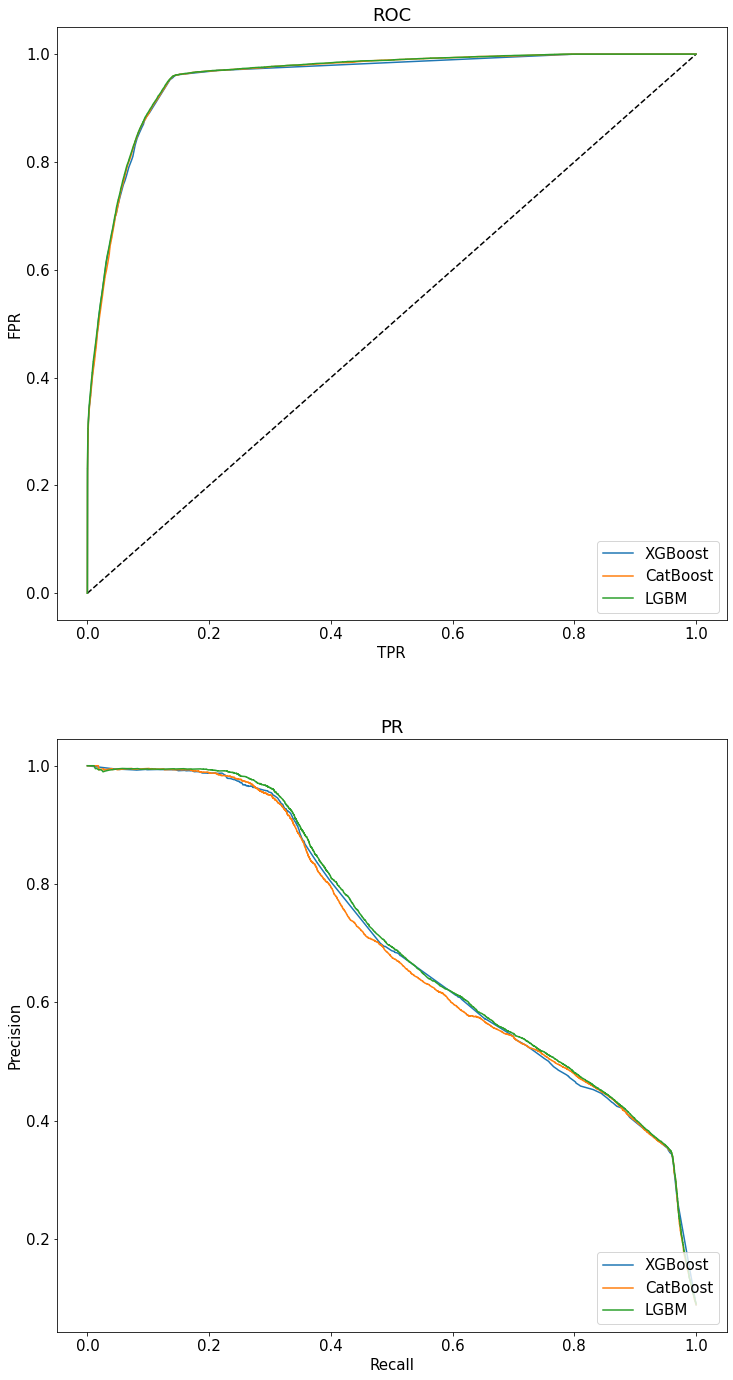

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

for key, value in predictions.items():
    fpr, tpr, roc_thresholds = roc_curve(y_test, value)
    precision, recall, pr_thresholds = precision_recall_curve(y_test, value)
    ax1.plot(fpr, tpr, label=key)
    ax2.plot(recall, precision, label=key)
    print(key, ": AUC_PR = %.3f" % auc(recall, precision))
    print(key, ": AUC_ROC = %.3f" % auc(fpr, tpr))
    
    
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");
plt.savefig("roc-pr.png")

Результаты работы моделей похожи. Выбор сделан в пользу LGBM, из-за наименьшей ее ресурсозатратности. Особенно важно при обработке большого количества данных.

In [50]:
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]

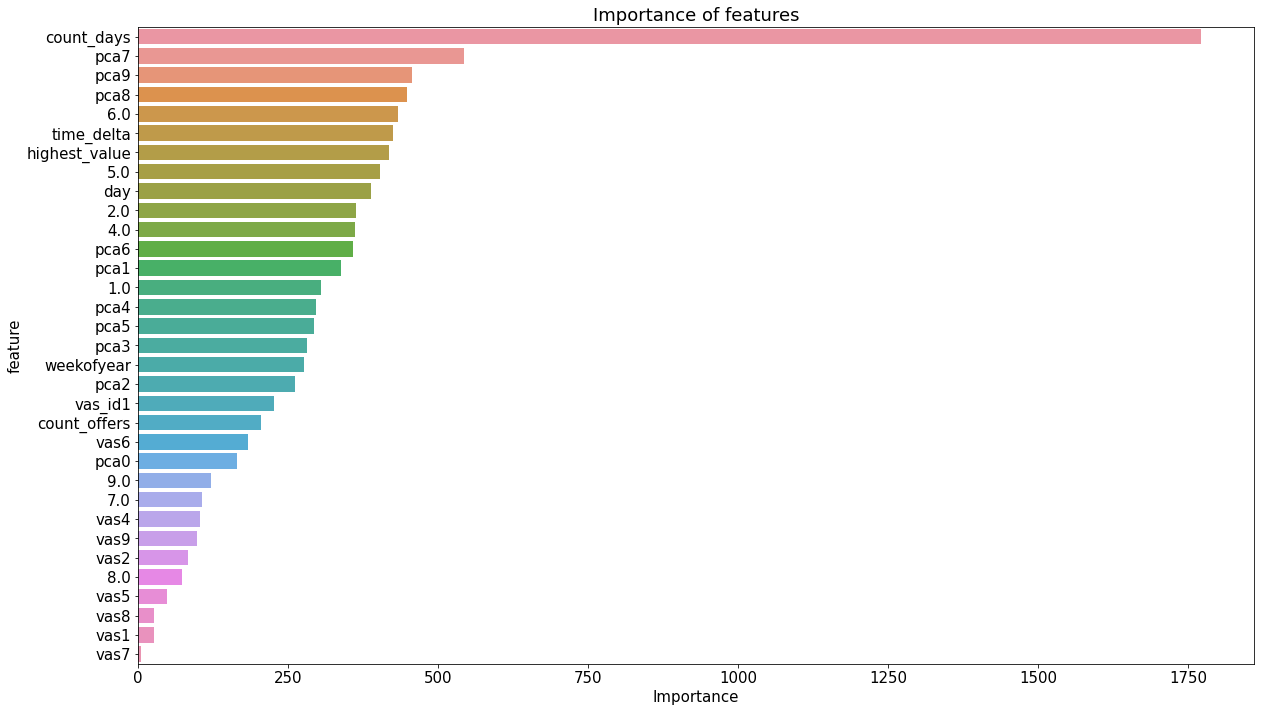

In [51]:
important_features_top = show_feature_importances(cols, model_lgb.feature_importances_, get_top=None)

In [52]:
# Проверим работу модели с помощью кросс-валидации:
cv_scores = cross_val_score(model_lgb, data, y, cv=6, scoring=make_scorer(f1_score, average='macro'))
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7897388310853479+-0.006042365511785947


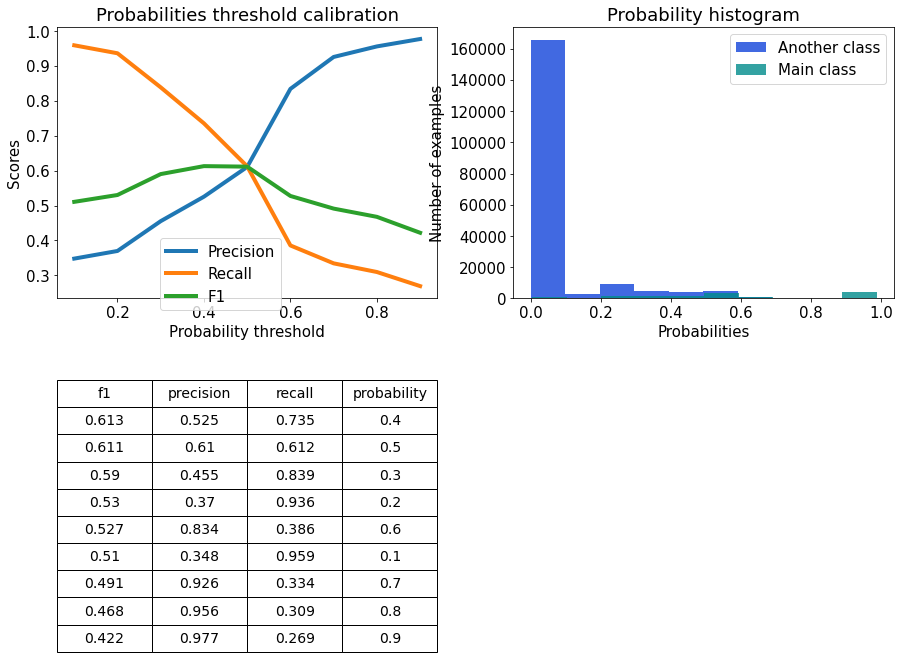

In [53]:
show_proba_calibration_plots(lgb_test_proba, y_test)

Confusion matrix, without normalization
[[186920   5947]
 [  5794   9253]]


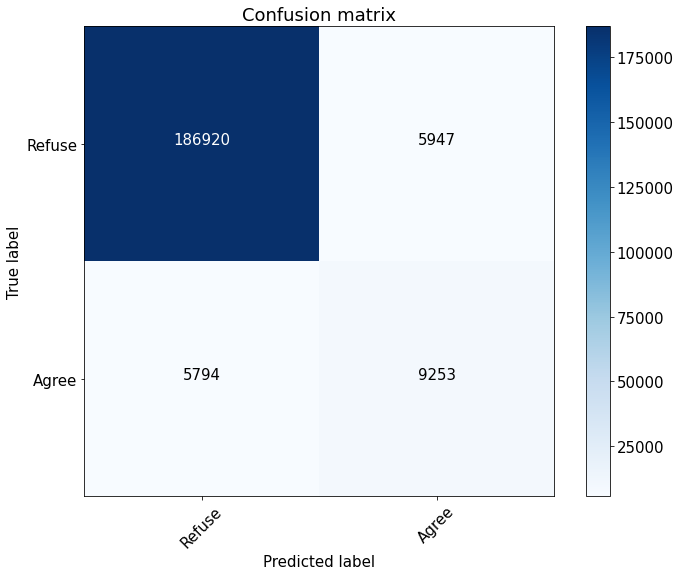

In [54]:
cnf_matrix = confusion_matrix(y_test, lgb_test_proba>0.49)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Refuse', 'Agree'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

#### Cохранение пайплайна

In [55]:
full_pipeline = Pipeline([
    ('prepare', DataTransform(data_features)),
    ('pca_transformer', PCA_transformer(data_features.columns[2:])),
    ('features',feats),
    ('classifier', LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2))
])

full_pipeline.fit(X, y)

Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%


Pipeline(steps=[('prepare',
                 DataTransform(features=            id    buy_time           0            1           2            3  \
13     2046132  1534712400  300.820038  1599.480835  286.879211  1585.013184   
16     2050810  1540760400  -86.209969    91.820885  -84.480789   110.333199   
19     2070757  1540760400  -96.799973  -408.179108 -110.740784  -460.786804   
20     2071522  1544994000  -94.939972  -363.699127 -108.880783  -411.226807   
22     2075318  1533502800  -75.639969   669.690918  -89...
                                                                                          'pca9']))])),
                                                ('other',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(columns=['highest_value',
                                                                                          'count_days',
                     

In [56]:
lgb_train_proba = full_pipeline.predict_proba(X)[:, 1]

Memory usage of the dataframe is 9.52 MB
Memory usage after optimization is: 9.52 MB
Decreased by 0.0%


In [57]:
print(classification_report(y, lgb_train_proba > 0.49))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    771467
         1.0       0.51      0.77      0.62     60186

    accuracy                           0.93    831653
   macro avg       0.75      0.86      0.79    831653
weighted avg       0.95      0.93      0.94    831653



In [58]:
with open("lgbm_pipeline.pickle", "wb") as f:
    pickle.dump(full_pipeline, f)

Запись результата

In [59]:
class PredictProbability(luigi.Task):
    
    test_csv = luigi.Parameter()
    
  
    
    def run(self):
        
        test = pd.read_csv(self.test_csv, float_precision="high", encoding='utf8',sep=',')
        
      
        with open('lgbm_pipeline.pickle', 'rb') as model_file:
            model = pickle.load(model_file)
        

        test['target'] = model.predict_proba(test)[:, 1]
        
        
        test.to_csv('answers_test.csv', float_format='%20f', index=False, encoding='utf8',sep=',')
        
  

    def output(self):
        return luigi.LocalTarget('answers_test.csv')

In [60]:
# luigid --port 8082

In [61]:
if __name__ == '__main__':
    luigi.build([PredictProbability('data_test.csv')])

DEBUG: Checking if PredictProbability(test_csv=data_test.csv) is complete
INFO: Informed scheduler that task   PredictProbability_data_test_csv_b958939509   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=429588298, workers=1, host=iMac-Alena.local, username=alenakukhta, pid=9820) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 PredictProbability(test_csv=data_test.csv)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [62]:
answers = pd.read_csv('answers_test.csv')
answers.head(5)

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.000933
1,2000860,4.0,1548018000,0.414040
2,1099444,2.0,1546808400,0.000876
3,1343255,5.0,1547413200,0.000809
4,1277040,2.0,1546808400,0.001009


### Персональные предложения пользователям

Каким абонентам имеет смысл предлагать услугу? Выше определен оптимальный порог для f1-macro - 0.49. Теперь определим оптимальный порог для увеличения f1 именно по миноритарному (позитивному) классу:

In [63]:
precision, recall, thresholds = precision_recall_curve(y_test, lgb_test_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score(y_test, lgb_test_proba)))

Best Threshold=0.425000, F-Score=0.615, Precision=0.539, Recall=0.716, Roc_auc=0.956


In [64]:
confusion_matrix(y_test, lgb_test_proba>0.425)

array([[183663,   9204],
       [  4280,  10767]])

Для ML оптимальным порогом определения целевого абонента является 0.425. 

Однако, важно учесть экономические и маркетинговые приоритеты компании на данном этапе. Если компании важно охватить как можно больше клиентов, не упустить никого (увеличить recall), то порог следует снизить. Если комапния не намерена тратить ресурсы на большое количество клиентов и заинтересована в том, чтобы ML-алгоритм макимально точно показал только тех клиентов, которые с максимальной вероятностью воспользуются услугой (увелилчить precision), порог следует повысить. Для того, чтобы предложить клиенту услугу, компании придется потратить деньги, поэтому обзванивать всех клиентов зачастую нецелесообразно. Чтобы определить, какой именно порог будет наиболее выгодным, можно подсчитать затраты на кандидата и прибыль с каждого true positive клиента.

В качестве упрощенного примера предположим, что затраты на кандидата = 1 доллар, а прибыль с true positive клиента = 2 доллара. Количество пороговых значений thresholds уменьшено для экономии времени.

In [65]:
expenses = 1
profit = 2
thresholds = np.linspace(0.3, 0.8, 51)

In [66]:
max_revenue = 0
best_t = 0
for t in thresholds:
    cnf_matrix = confusion_matrix(y_test, lgb_test_proba>t)
    add_summ = cnf_matrix[1,1]*profit - np.sum(cnf_matrix[:,1])*expenses
    if add_summ > max_revenue:
        max_revenue = add_summ
        best_t = t
print(f'Максимальный доход: {max_revenue} достигнут при пороге {best_t}')

Максимальный доход: 4667 достигнут при пороге 0.62


Возможно, если пользователь не согласится на эту конкретную услугу, его заинтересует другая.

Для определения, какая из 8 указанных услуг больше подойдет пользователю, можно решить с помощью мультиклассовой классификации, используя признак "vas_id" в качестве целефой переменной. Для этого возьмем предобработанные в пайплайне выше данные из data_train.csv и уберем оттуда новые признаки, зависящие непосредственно от 'vas_id'.

In [67]:
df = pd.read_csv('data.csv')

In [68]:
df = df.drop(['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0',
 '8.0', '9.0', 'vas_id1'], axis=1)

In [69]:
df['vas_id'] = data_train['vas_id']

In [70]:
df.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,highest_value,count_days,day,weekofyear,count_offers,time_delta,id,vas_id
0,7.992663e+08,-705327296.0,-124003592.0,-8432.897461,38371.093750,-1031.558594,-54933.140625,10510.473633,-602.851685,-2248.724854,40.0,70.0,17.0,38.0,1.0,0.0,540968,8.0
1,1.218462e+09,747000128.0,-192952112.0,37546.773438,-50069.484375,4075.265381,-15417.874023,-6934.746094,-5694.678223,-419.269470,23.0,7.0,16.0,29.0,1.0,0.0,1454121,4.0
2,-6.786284e+08,-264398880.0,-85792040.0,-127631.210938,120743.375000,-10283.589844,-60927.773438,-6355.877930,-6193.811523,-764.460388,5.0,35.0,13.0,33.0,1.0,0.0,2458816,1.0


In [71]:
#разделим пользователей на кластеры
# k8 = KMeans(n_clusters=8, precompute_distances = True, n_jobs=-1)
k8 = KMeans(n_clusters=8)
k8.fit(df)
df['kmeans'] =k8.predict(df)

In [72]:
result = LabelEncoder()
y = result.fit_transform(data_train['vas_id'])

In [73]:
# для обучения возьмем только пользователей, подключивших услугу
df['target'] = data_train['target']
df['vas_id'] = y

df_train = df.loc[df.target==1]

In [74]:
X = df_train.drop(['vas_id', 'target'], axis=1)
y = df_train['vas_id']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=13)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45139, 18) (45139,) (15047, 18) (15047,)


In [76]:
X_id = X_test['id']
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

In [77]:
%%time

model_lgb = LGBMClassifier(objective='multiclass',
                     max_depth=10,
                     n_estimators=200,
                     num_leaves = 100,
                     learning_rate=0.045,
                     class_weight = 'balanced',
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

CPU times: user 31.1 s, sys: 313 ms, total: 31.4 s
Wall time: 4.05 s


LGBMClassifier(class_weight='balanced', learning_rate=0.045, max_depth=10,
               n_estimators=200, num_leaves=100, objective='multiclass',
               reg_lambda=0.2)

In [78]:
preds = model_lgb.predict_proba(X_test)

In [79]:
df_preds = pd.DataFrame(preds, columns = ['1','2','4', '5','6','7','8', '9'])
df_preds['best_service'] = [df_preds.iloc[row].idxmax() for row in range(df_preds.shape[0])]
df_preds['id'] = X_id.values
df_preds = df_preds[['id', 'best_service','1','2','4', '5','6','7','8', '9' ]]

In [80]:
df_preds.best_service.value_counts(normalize=True)

6    0.396557
4    0.254004
2    0.117565
1    0.115704
5    0.054496
9    0.045059
8    0.009902
7    0.006712
Name: best_service, dtype: float64

Наибольший процент подключений у услуги 6, вторая по привлекательности - услуга № 4, как и в первоначальном датасете data_train.csv, а по подключению услуг 7, 8 и 9 мало наблюдений.

In [81]:
data_train[data_train.target==1]['vas_id'].value_counts()

6.0    24704
4.0    21765
1.0     5664
2.0     4797
5.0     1692
9.0     1004
8.0      347
7.0      213
Name: vas_id, dtype: int64

Оптимальной услуги для абонента 862975 является услуга № 8:

In [82]:
df_preds.loc[df_preds['id']==862975]

,id,best_service,1,2,4,5,6,7,8,9
7898,862975,8,0.104866,0.091815,0.066337,0.128631,0.007982,0.008014,0.494432,0.097922


Если идти от обратного и искать, каким абонентам продать услугу № 1, то наиболее подходящие кандидаты:

In [83]:
df_preds.sort_values('1', ascending=False).head(3)

,id,best_service,1,2,4,5,6,7,8,9
13176,2521946,1,0.825278,0.014130,0.112268,0.020391,0.026789,0.000145,0.000573,0.000427
6062,3686508,1,0.817292,0.051909,0.093723,0.017688,0.008805,0.003694,0.001798,0.005091
14176,3242547,1,0.805830,0.053394,0.075873,0.041312,0.003206,0.009934,0.000945,0.009505


По бинарной классификации (включить в выборку одинаковые данные об абонентах со всеми возможными 'vas_id') оказывается, что некоторым пользователям не интересны никакие услуги, а другим интересны сразу несколько.

In [84]:
X_train = pd.concat([df, pd.get_dummies(data_train['vas_id'].astype('str'))], axis=1).drop(['target', 'vas_id', 'id'], axis=1)
y_train = df['target']

In [85]:
X_test['vas_id'] = 1

In [86]:
part = X_test.copy()
part['vas_id'] = 2
X_test = X_test.append(part)
part['vas_id'] = 4
X_test = X_test.append(part)
part['vas_id'] = 5
X_test = X_test.append(part)
part['vas_id'] = 6
X_test = X_test.append(part)
part['vas_id'] = 7
X_test = X_test.append(part)
part['vas_id'] = 8
X_test = X_test.append(part)
part['vas_id'] = 9
X_test = X_test.append(part)

X_test = pd.concat([X_test, pd.get_dummies(X_test['vas_id'].astype('str'))], axis=1)

In [87]:
results = pd.DataFrame()
results['id'] = np.append(X_id, [X_id, X_id, X_id, X_id, X_id, X_id, X_id])
results['vas_id'] = X_test['vas_id'].values

X_test.drop('vas_id', axis = 1, inplace=True)

In [88]:
model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.045, max_depth=13, num_leaves=100,
               objective='binary', reg_lambda=0.2, scale_pos_weight=2.86)

In [89]:
binary_preds = model_lgb.predict_proba(X_test)[:, 1]

In [90]:
results['preds']= binary_preds
results.head(5)

,id,vas_id,preds
0,1946568,1,0.037022
1,3951560,1,0.031598
2,367758,1,0.001163
3,817454,1,0.985614
4,1421442,1,0.001166


In [91]:
results.loc[results['id']==817454]

,id,vas_id,preds
3,817454,1,0.985614
15050,817454,2,0.985614
30097,817454,4,0.985327
45144,817454,5,0.985614
60191,817454,6,0.984958
75238,817454,7,0.985614
90285,817454,8,0.985614
105332,817454,9,0.985614


In [92]:
results.loc[results['id']==1946568]

,id,vas_id,preds
0,1946568,1,0.037022
15047,1946568,2,0.050434
30094,1946568,4,0.409172
45141,1946568,5,0.021593
60188,1946568,6,0.692433
75235,1946568,7,0.034968
90282,1946568,8,0.037625
105329,1946568,9,0.057174


**Выводы:**
1) наблюдается значительный дисбаланс по количеству предложений разных услуг;

2) не очевиден критерий оптимально подобранной пары абонент-услуга. Если он подключил услугу, возможно, другую он подключил бы охотнее.

Определение абонентов для взаимодействия возможно методом UPLIFT. Некоторые негативно воспринимают любое взаимодействие с ними ("спящие собаки"), другие лояльны и без дополнительных затрат на их удержание.

Решение по рекомендательным системам с библиотекой imlicit, не сработало. Возможно было бы иначе, если было бы больше абонентов с различными вариантами услуг.

In [93]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [94]:
user_item_matrix = pd.pivot_table(data_train,
                                          index='id',
                                          columns='vas_id',
                                          values='target',
                                          aggfunc='sum',
                                          fill_value=0
                                          )
user_item_matrix = user_item_matrix.astype(float)

In [95]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [96]:
model = AlternatingLeastSquares(factors=100,
                                        regularization=0.1,
                                        iterations=8,
                                        num_threads=15,
                                        calculate_training_loss=True)
model.fit(csr_matrix(user_item_matrix).T.tocsr())

  0%|          | 0/8 [00:00<?, ?it/s]

In [97]:
def get_recommendations(user, model, N=2):
    res = [(id_to_itemid[rec[0]], rec[1]) for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix),
                                    N=N, 
                                    filter_already_liked_items=True, 
                                    filter_items=False, 
                                    recalculate_user=True)]
    return res

In [98]:
get_recommendations(342, model=model, N=1)

[(7.0, -0.0004914778898682595)]

In [99]:
data_train.loc[data_train.id ==342]

,Unnamed: 0,id,vas_id,buy_time,target
14041,14041,342,1.0,1541365200,0.0
14042,14042,342,2.0,1542574800,1.0


**Вывод:** 
Абоненту рекомендуется услуга c нулевой вероятностью. При большем разнообразии услуг был бы иной искод.